In [23]:
import networkx as nx
import pickle
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

In [108]:
def get_coordinates(tumor_seg, values=[1, 2, 4]):

    coordinates = {}
    
    for value in values:
        # Get the indices where the value is present in the image
        indices = np.where(tumor_seg == value)

        # Convert the indices to a list of tuples representing coordinates
        coords = list(zip(*indices))

        # Add the coordinates to the dictionary
        coordinates[value] = coords

    return coordinates


def get_supervoxel_values(slic_image, coordinates_dict):

    supervoxel_values = {}

    for value, coordinates in coordinates_dict.items():
        value_list = []
        for coord in coordinates:
            # Get the value of the supervoxel at the given coordinate
            supervoxel_value = slic_image[coord]

            # Add the value to the list
            value_list.append(supervoxel_value)
        
        # Add the list of supervoxel values to the dictionary
        supervoxel_values[value] = list(np.unique(value_list))

    return supervoxel_values


def assign_labels_to_graph(tumor_seg, slic_image, graph):


    new_graph = nx.Graph()
    new_graph.add_nodes_from(graph.nodes())
    new_graph.add_edges_from(graph.edges())


    coords = get_coordinates(tumor_seg)
    labels_supervoxel_dict = get_supervoxel_values(slic_image, coords)

    for label, supervoxel_list in labels_supervoxel_dict.items():
        for supervoxel in supervoxel_list:
            new_graph.nodes[str(int(supervoxel))]["label"] = label

    for n in graph.nodes():
        try:
            new_graph.nodes[str(int(n))]["label"]
        except:
            new_graph.nodes[str(int(n))]["label"] = 3
    
    return new_graph    


def generate_tumor_segmentation_from_graph(segmented_image, graph):
    # Create a dictionary to map node IDs to their labels
    node_label_map = {n: graph.nodes[str(int(n))]['label'] for n in graph.nodes()}
    
    # Create a mask for labels to keep (1, 2, and 4)
    labels_to_keep = np.array([1, 2, 4])
    
    # Replace node IDs in segmented_image with their corresponding labels
    label_image = np.vectorize(node_label_map.get)(segmented_image)
    
    # Use np.isin to create a boolean mask for the labels we want to keep
    mask = np.isin(label_image, labels_to_keep)
    
    # Use np.where to create the segmented tumor image
    segmented_tumor = np.where(mask, label_image, 0)
    
    # Cast the output to float64
    return segmented_tumor.astype(np.float64)

def DGLGraph_plotter(nx_graph):
    # Color Map
    color_map = {3: (0.5, 0.5, 0.5, 0.2), 1: 'blue', 2: 'yellow', 4: 'red'}

    # Assign color to nodes taking their label
    node_colors = [color_map[nx_graph.nodes[node]['label']] for node in nx_graph.nodes]

    # Prepare the list of colors based on the edge labels
    edge_colors = []
    for u, v in nx_graph.edges():
        if nx_graph.nodes[u]['label'] in {1, 2, 4} and nx_graph.nodes[v]['label'] in {1, 2, 4}:
            edge_colors.append('red')
        else:
            edge_colors.append((0, 0, 0, 0.2))  # Black color with 0.2 transparency

    plt.figure(figsize=(15, 11))
    # Draw the graph
    pos = nx.spring_layout(nx_graph)
    nx.draw(nx_graph, pos, node_color=node_colors, edge_color=edge_colors)

    # Create a dictionary with node keys for nodes with labels 1, 2, and 4
    label_dict = {node: node for node in nx_graph.nodes if nx_graph.nodes[node]['label'] in {1, 2, 4}}

    # Draw node labels
    nx.draw_networkx_labels(nx_graph, pos, labels=label_dict, font_size = 8)

    # Create the legend
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', label='Enhanced', markerfacecolor='red', markersize=8),
        plt.Line2D([0], [0], marker='o', color='w', label='Edema', markerfacecolor='yellow', markersize=8),
        plt.Line2D([0], [0], marker='o', color='w', label='Necrosis', markerfacecolor='blue', markersize=8),
        plt.Line2D([0], [0], marker='o', color='w', label='Other', markerfacecolor=color_map[3], markersize=8)
    ]

    # Display the legend
    plt.legend(handles=legend_elements, loc='best')
    plt.show()

def generate_labels(segmented_data, ground_truth_data):
    labels = np.zeros_like(segmented_data, dtype=np.uint8)

    # Definisci le etichette e le soglie per ciascuna classe
    labels_map = {
        'core_tumor': 1,
        'enhancing_tumor': 2,
        'peritumoral_tissue': 4
    }
    thresholds = {
        'core_tumor': 0.5,
        'enhancing_tumor': 0.5,
        'peritumoral_tissue': 0.5
    }

    # Trova i segmenti SLIC che intersecano la zona tumorale
    tumor_mask = (ground_truth_data != 0)
    intersecting_segments = np.unique(segmented_data[tumor_mask])

    # Assegna le etichette solo ai segmenti che intersecano la zona tumorale
    for i in intersecting_segments:
        superpixel_mask = (segmented_data == i)
        superpixel_sum = np.sum(superpixel_mask)

        if superpixel_sum == 0:
            continue

        for voxel_value in labels_map.values():
            intersection = np.sum(superpixel_mask & (ground_truth_data == voxel_value))
            intersection_ratio = intersection / superpixel_sum

            if intersection_ratio > thresholds[list(labels_map.keys())[list(labels_map.values()).index(voxel_value)]]:
                labels[superpixel_mask] = voxel_value
                break
    return labels

def _3Dplotter(numpy_image):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))
    ax1.imshow(numpy_image[numpy_image.shape[0] // 2, :, :])
    ax1.set_title("Sagittale")
    ax2.imshow(numpy_image[:, numpy_image.shape[1] // 2, :])
    ax2.set_title("Coronale")
    ax3.imshow(numpy_image[:, :, numpy_image.shape[2] // 2])
    ax3.set_title("Assiale")
    plt.show()


def DGLGraph_plotter(nx_graph):
    # Color Map
    color_map = {3: (0.5, 0.5, 0.5, 0.2), 1: 'blue', 2: 'yellow', 4: 'red'}

    # Assign color to nodes taking their label
    node_colors = [color_map[nx_graph.nodes[node]['label']] for node in nx_graph.nodes]

    # Prepare the list of colors based on the edge labels
    edge_colors = []
    for u, v in nx_graph.edges():
        if nx_graph.nodes[u]['label'] in {1, 2, 4} and nx_graph.nodes[v]['label'] in {1, 2, 4}:
            edge_colors.append('red')
        else:
            edge_colors.append((0, 0, 0, 0.2))  # Black color with 0.2 transparency

    plt.figure(figsize=(15, 11))
    # Draw the graph
    pos = nx.spring_layout(nx_graph)
    nx.draw(nx_graph, pos, node_color=node_colors, edge_color=edge_colors)

    # Create a dictionary with node keys for nodes with labels 1, 2, and 4
    label_dict = {node: node for node in nx_graph.nodes if nx_graph.nodes[node]['label'] in {1, 2, 4}}

    # Draw node labels
    nx.draw_networkx_labels(nx_graph, pos, labels=label_dict, font_size = 8)

    # Create the legend
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', label='Enhanced', markerfacecolor='red', markersize=8),
        plt.Line2D([0], [0], marker='o', color='w', label='Edema', markerfacecolor='yellow', markersize=8),
        plt.Line2D([0], [0], marker='o', color='w', label='Necrosis', markerfacecolor='blue', markersize=8),
        plt.Line2D([0], [0], marker='o', color='w', label='Other', markerfacecolor=color_map[3], markersize=8)
    ]

    # Display the legend
    plt.legend(handles=legend_elements, loc='best')
    plt.show()



In [215]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import ast

def plot_percentiles_mean(labeled_graph):
    percentile_indices = {
        10: [0, 5, 10, 15],
        25: [1, 6, 11, 16],
        50: [2, 7, 12, 17],
        75: [3, 8, 13, 18],
        90: [4, 9, 14, 19]
    }

    # Prepare data for each label
    for label in [1, 2, 3, 4]:
        # Filter nodes with the current label
        nodes = [node for node, data in labeled_graph.nodes(data=True) if data['label'] == label]
        
        # Calculate the mean of the desired percentiles for the filtered nodes
        means = []
        for percentile, indices in percentile_indices.items():
            percentile_values = [np.mean([ast.literal_eval(labeled_graph.nodes[node]['feature'])[i] for i in indices]) for node in nodes]
            mean_value = np.mean(percentile_values)
            means.append(mean_value)
        
        # Plot the results
        plt.plot([10, 25, 50, 75, 90], means, label=f'Label {label}')

    plt.xlabel('Percentile')
    plt.ylabel('Mean Value')
    plt.legend()
    plt.show()


def dgl_to_simple_graph(dgl_graph):
    nx_multigraph = dgl_graph.to_networkx().to_undirected()
    nx_graph = nx.Graph()
    
    # Copy node attributes
    for node, attrs in dgl_graph.ndata.items():
        for u, attr_values in enumerate(attrs):
            if node == 'label':
                attr_values = int(attr_values)
            elif node == 'feat':
                attr_values = attr_values.tolist()
            nx_graph.add_node(u, **{node: attr_values})
    
    # Copy edges (while removing multiple edges)
    for u, v, data in nx_multigraph.edges(data=True):
        if nx_graph.has_edge(u, v):
            continue
        nx_graph.add_edge(u, v, **data)
    
    return nx_graph

In [206]:
slic = nib.load('../datasets/old_dataset/BraTS2021_00002/BraTS2021_00002_SLIC.nii.gz').get_fdata()

In [207]:
graph = nx.read_graphml('new_graphs/brain_graph_00002.graphml')

In [208]:
with open('../labels_module/labels/labels_00002.pkl', 'rb') as f:
    labels = pickle.load(f)

In [209]:
seg =  nib.load('../datasets/old_dataset/BraTS2021_00002/BraTS2021_00002_seg.nii.gz').get_fdata()

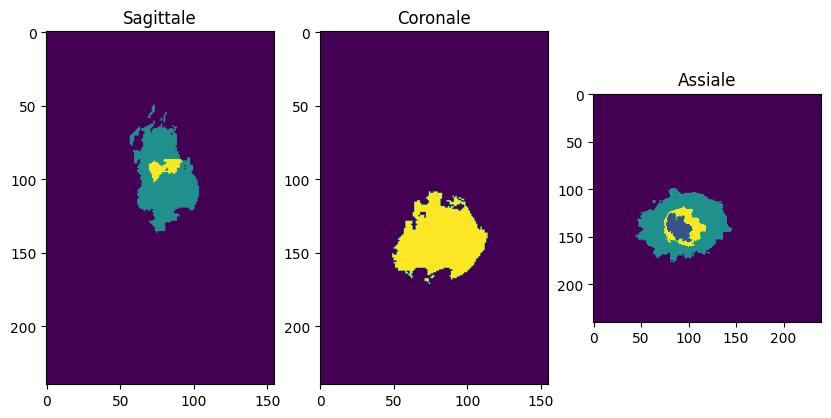

In [210]:
_3Dplotter(labels)

In [211]:
labeled_graph = assign_labels_to_graph(labels, slic, graph)

In [212]:
nx.get_node_attributes(labeled_graph, 'feature').items()

dict_items([('3986', '[1.7160294002634988, 2.0935684423891754, 2.4076809254377385, 2.5858793533210576, 2.7066918468012737, 1.4984980132120451, 1.8442319785107966, 2.0492602602577303, 2.2060465933583275, 2.289665971011979, 1.49960920493774, 1.6018341608959052, 1.7891758851622517, 2.0811461950565953, 2.3216505520204103, 1.18177686693495, 1.3562269071220614, 1.548909255547256, 1.7208730718837197, 1.97239605144091]'), ('3419', '[1.407957541888947, 1.407957541888947, 1.407957541888947, 1.407957541888947, 1.407957541888947, 0.8834131679712433, 0.8834131679712433, 0.8834131679712433, 0.8834131679712433, 0.8834131679712433, 2.8778787356157363, 2.8778787356157363, 2.8778787356157363, 2.8778787356157363, 2.8778787356157363, 1.1179637881016595, 1.1179637881016595, 1.1179637881016595, 1.1179637881016595, 1.1179637881016595]'), ('3420', '[0.4801175919608848, 0.5705759464541968, 0.6528794576375944, 0.7382032811579973, 0.7597985143675859, 0.3768727071847007, 0.4371751429926224, 0.5879312325124266, 0.

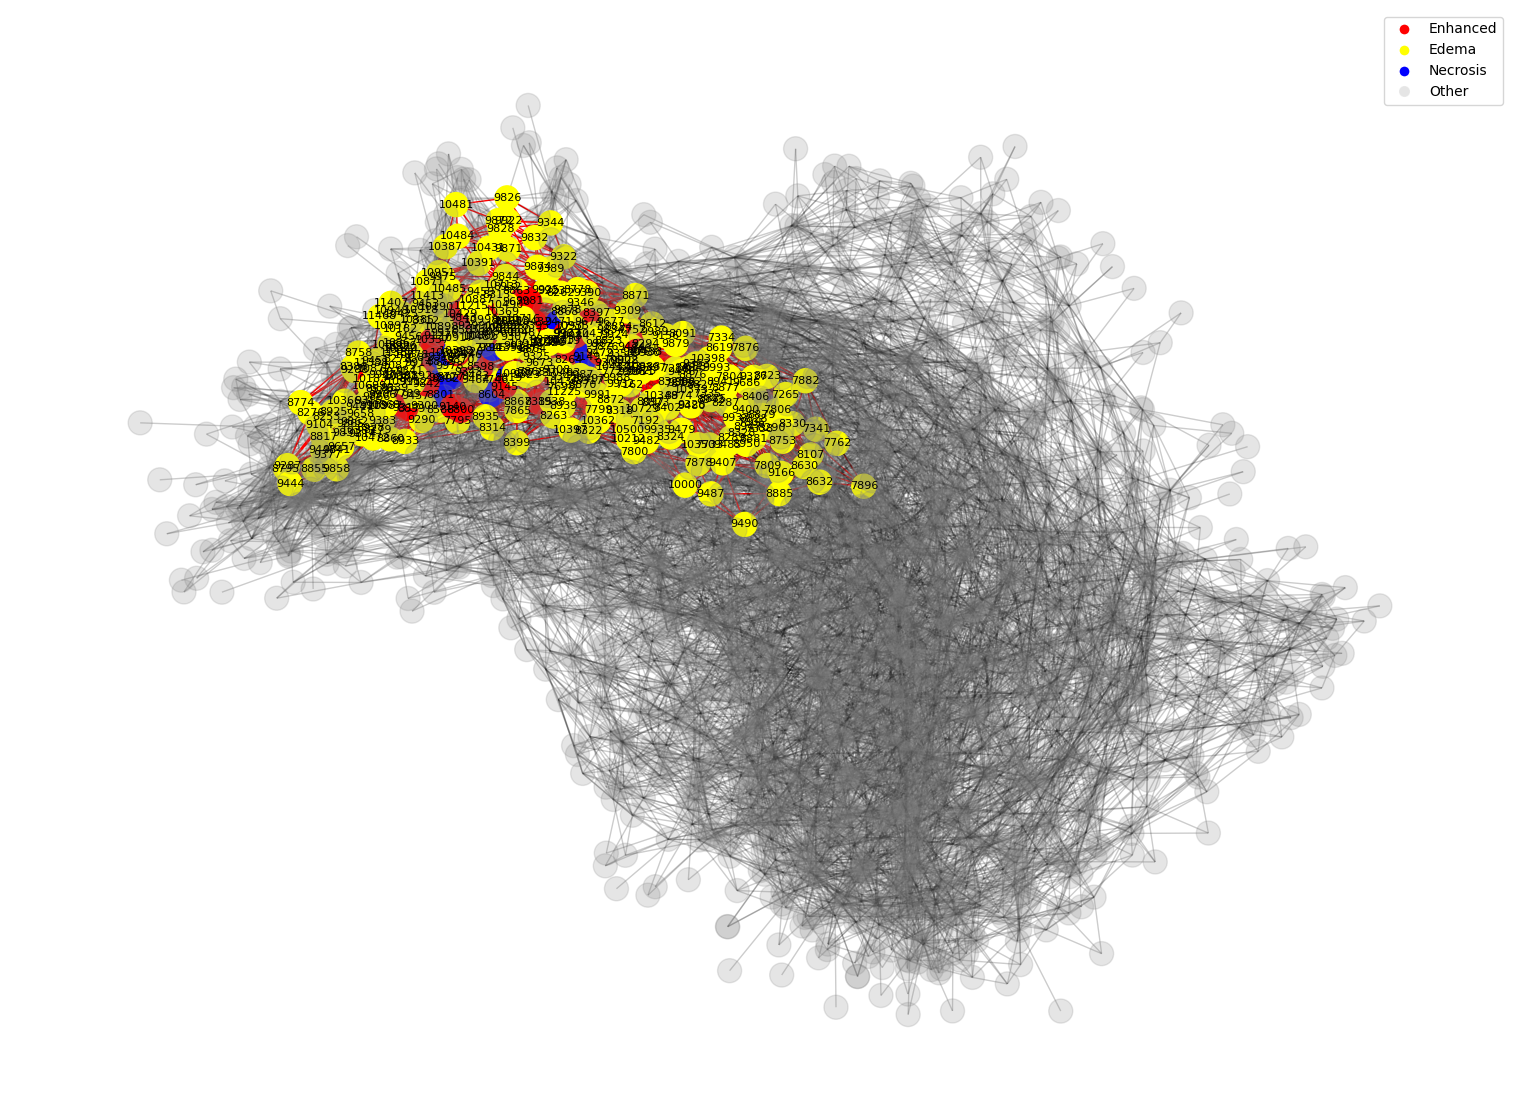

In [213]:
DGLGraph_plotter(labeled_graph)

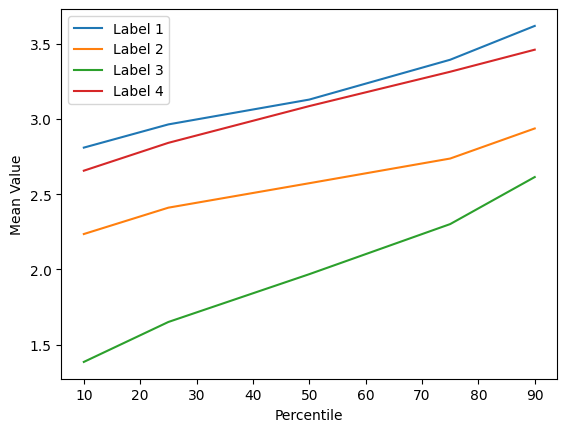

In [216]:
plot_percentiles_mean(labeled_graph)

In [217]:
import dgl 

def load_dgl_graphs_from_bin(file_path, ids_path):
    dgl_graph_list, _ = dgl.load_graphs(file_path)
    with open(f'{ids_path}', 'rb') as file:
        ids = pickle.load(file)
    return dgl_graph_list, ids

dgl_train_graphs, t_ids = load_dgl_graphs_from_bin('./DGL_graphs/FIXED_TRAIN_dgl_graphs_fix.bin', './DGL_graphs/FIXED_TRAIN_patient_ids_fix.pkl')

In [218]:
converted = dgl_to_simple_graph(dgl_train_graphs[0])
print(t_ids[0])

00002


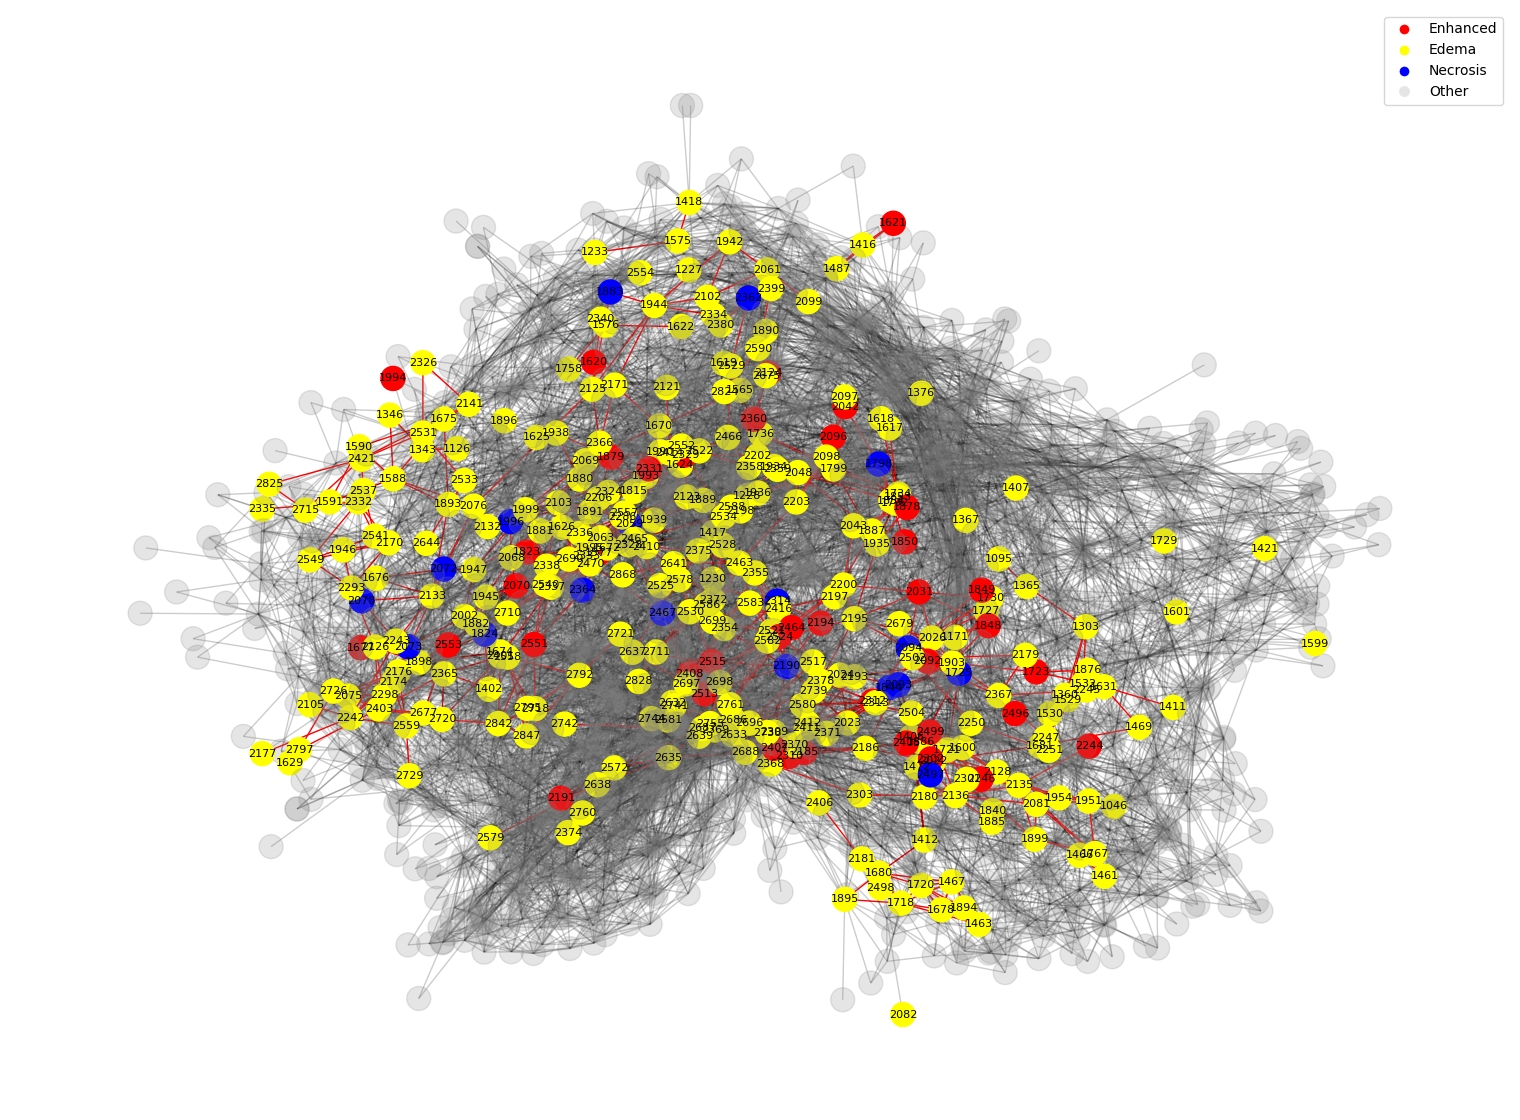

In [219]:
DGLGraph_plotter(converted)

In [232]:
a = np.array(list(nx.get_node_attributes(converted, 'label').values()))
b = np.array(list(nx.get_node_attributes(labeled_graph, 'label').values()))

In [236]:
np.array_equal(a,b)

True